<a href="https://colab.research.google.com/github/DayanaS05/NMPHASE1/blob/main/email_spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix,
                             precision_score, recall_score, f1_score)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [14]:
sms = pd.read_csv('/content/spam (1).csv', encoding='latin-1')
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [15]:
sms = sms.dropna(axis=1)
sms = sms.rename(columns={'v1': 'label', 'v2': 'Text'})
sms['label_enc'] = sms['label'].map({'ham': 0, 'spam':1})
sms.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


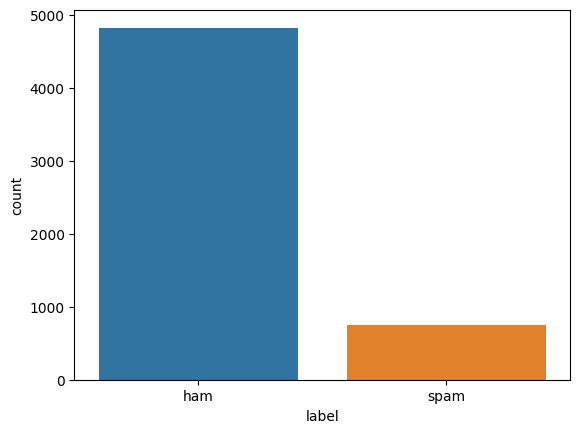

In [16]:
sns.countplot(x=sms['label'])
plt.show()

In [17]:
avg_words_len = round(sum([len(i.split()) for i in sms['Text']])/len(sms['Text']))
print(avg_words_len)

15


In [18]:
s = set()
for sent in sms['Text']:
    for word in sent.split():
        s.add(word)
total_words = len(s)
print(total_words)

15585


In [19]:
X_train, X_test, y_train, y_test = train_test_split(sms['Text'], sms['label_enc'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4457,), (1115,), (4457,), (1115,))

In [20]:
tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec, X_test_vec = tfidf_vec.transform(X_train), tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec, y_train)

MultinomialNB()

In [21]:
y_pred = baseline_model.predict(X_test_vec)
nb_accuracy = accuracy_score(y_test, y_pred)
print(nb_accuracy)
print(classification_report(y_test, y_pred))

0.9623318385650225
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



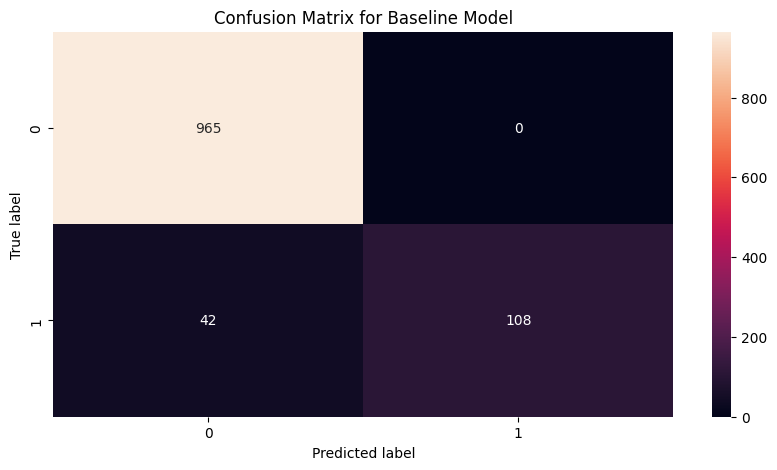

In [22]:
plt.figure(figsize=(10,5))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix for Baseline Model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [23]:
MAXTOKENS = total_words
OUTPUTLEN = avg_words_len

text_vec = TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN)

text_vec.adapt(X_train)

In [24]:
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

In [25]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)

x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(label_smoothing=0.5), metrics=['accuracy'])
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128  

In [26]:
history_1 = model_1.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), validation_steps=int(0.2*len(X_test)))

Epoch 1/5
140/140 [==============================] - 9s 51ms/step - loss: 0.6049 - accuracy: 0.9165 - val_loss: 0.5771 - val_accuracy: 0.9722
Epoch 2/5
140/140 [==============================] - 5s 33ms/step - loss: 0.5702 - accuracy: 0.9868 - val_loss: 0.5733 - val_accuracy: 0.9803
Epoch 3/5
140/140 [==============================] - 6s 45ms/step - loss: 0.5659 - accuracy: 0.9946 - val_loss: 0.5724 - val_accuracy: 0.9830
Epoch 4/5
140/140 [==============================] - 5s 34ms/step - loss: 0.5642 - accuracy: 0.9980 - val_loss: 0.5723 - val_accuracy: 0.9830
Epoch 5/5
140/140 [==============================] - 4s 31ms/step - loss: 0.5635 - accuracy: 0.9991 - val_loss: 0.5725 - val_accuracy: 0.9821


<Axes: >

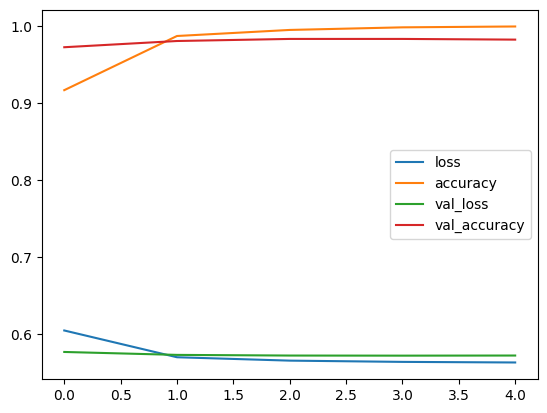

In [27]:
pd.DataFrame(history_1.history).plot()

In [28]:
def compile_model(model):
    """
    compile the model with adam optimizer
    """
    model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

def fit_model(model, epochs, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    """
    fit the model with given epochs, train and test data
    """
    history = model.fit(X_train, y_train, epochs=epochs,
                       validation_data=(X_test, y_test),
                       validation_steps=int(0.2*len(X_test)))
    return history

X, y = np.asanyarray(sms['Text']), np.asanyarray(sms['label_enc'])

def evaluate_model(model, X, y):
    """
    evaluate the model and returns accuracy, precision, recall and f1_score
    """
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)

    model_results_dict = {'accuracy': accuracy,
                          'precision': precision,
                          'recall': recall,
                          'f1-score': f1}
    return model_results_dict

In [29]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)

bi_lstm = layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)

x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

In [30]:
compile_model(model_2)
history_2 = fit_model(model_2, epochs=5)

Epoch 1/5
140/140 [==============================] - 28s 116ms/step - loss: 0.0588 - accuracy: 0.9814 - val_loss: 0.1151 - val_accuracy: 0.9803
Epoch 2/5
140/140 [==============================] - 12s 86ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 0.1133 - val_accuracy: 0.9848
Epoch 3/5
140/140 [==============================] - 13s 95ms/step - loss: 4.9424e-05 - accuracy: 1.0000 - val_loss: 0.1284 - val_accuracy: 0.9857
Epoch 4/5
140/140 [==============================] - 12s 86ms/step - loss: 2.1325e-05 - accuracy: 1.0000 - val_loss: 0.1363 - val_accuracy: 0.9857
Epoch 5/5
140/140 [==============================] - 12s 85ms/step - loss: 1.3151e-05 - accuracy: 1.0000 - val_loss: 0.1421 - val_accuracy: 0.9857


In [31]:
model_3 = keras.Sequential()

# universal-sentence-encoder layer directly from tfhub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                          trainable=False, input_shape=[],
                          dtype=tf.string, name='USE')
model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation=keras.activations.relu))
model_3.add(layers.Dense(1, activation=keras.activations.sigmoid))
# Train the model
compile_model(model_3)
history_3 = fit_model(model_3, epochs=5)

Epoch 1/5
140/140 [==============================] - 11s 36ms/step - loss: 0.2788 - accuracy: 0.9219 - val_loss: 0.1104 - val_accuracy: 0.9695
Epoch 2/5
140/140 [==============================] - 3s 20ms/step - loss: 0.0776 - accuracy: 0.9794 - val_loss: 0.0730 - val_accuracy: 0.9749
Epoch 3/5
140/140 [==============================] - 3s 21ms/step - loss: 0.0545 - accuracy: 0.9838 - val_loss: 0.0592 - val_accuracy: 0.9794
Epoch 4/5
140/140 [==============================] - 3s 21ms/step - loss: 0.0454 - accuracy: 0.9859 - val_loss: 0.0545 - val_accuracy: 0.9812
Epoch 5/5
140/140 [==============================] - 4s 32ms/step - loss: 0.0414 - accuracy: 0.9874 - val_loss: 0.0504 - val_accuracy: 0.9821


In [35]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
model_3_results = evaluate_model(model_3, X_test, y_test)

total_results = pd.DataFrame({'MultinomialNB': baseline_model_results,
                              'Custom-Vec-Embedding Model': model_1_results,
                              'Bidirectional-LSTM Model': model_2_results,
                              'USE-Transfer learning Model': model_3_results}).transpose()
total_results

35/35 [==============================] - 1s 18ms/step


,accuracy,precision,recall,f1-score
MultinomialNB,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.982960,1.000000,0.873333,0.932384
Bidirectional-LSTM Model,0.985650,1.000000,0.893333,0.943662
USE-Transfer learning Model,0.982063,0.945205,0.920000,0.932432
